## Introduzione

L’obiettivo di questo progetto è costruire una rete neurale profonda capace di predire se pioverà il giorno successivo in diverse regioni dell’Australia, usando dati meteorologici storici. Il task è una classificazione binaria, in cui la variabile `RainTomorrow` assume 0 (non piove) o 1 (piove).

Il dataset originale, ottenuto dal Bureau of Meteorology australiano (via Kaggle), conteneva 99.516 osservazioni giornaliere da oltre 10 anni di registrazioni.

Il preprocessing è stato effettuato in un notebook separato (vedi [PreparingAustraliaWeatherDataset](#)), e include:
- rimozione osservazioni incomplete,
- normalizzazione numerica (MinMax),
- label encoding per le variabili categoriche,
- esportazione di un dataset pulito pronto per il training.

Il dataset finale contiene 39.574 righe e 21 feature predittive più la target.



##Background e letteratura
Recenti studi su dataset meteorologici australiani [1], [2] hanno evidenziato come le reti neurali artificiali (ANN, RNN) forniscano risultati migliori rispetto a metodi tradizionali (KNN, DT, RF) per la previsione della pioggia. In particolare, [2] mostra che combinazioni di ANN e Random Forest offrono prestazioni superiori su dati mensili australiani. Inoltre, altri lavori su modelli ibridi (MLP, ConvLSTM, CNN-LSTM) dimostrano l’efficacia delle reti profonde nella previsione meteorologica su scala globale [3]–[5].

##Bibliografia
[1] *M. Sarasa‑Cabezuelo, J. A. Ortega and M. L. Sein-Echaluce, “Prediction of Rainfall in Australia Using Machine Learning”* International Journal of Advanced Computer Science and Applications (IJACSA), vol. 13, no. 4, pp. 627–635, 2022.

[2] *M. Farman, N. A. Bakar, and I. O. Basir, “A Comparative Study of Machine Learning and Deep Learning Models for Rainfall Prediction in Australian Cities”* International Journal of Advanced Computer Science and Applications (IJACSA), vol. 16, no. 4, pp. 735–741, 2025.

[3] *A. Abbot, T. Nguyen, and L. K. Thomas, “Hybrid Neural Network Models for Monthly Rainfall Prediction: A Case Study in Queensland, Australia”* Expert Systems with Applications, vol. 220, p. 119846, 2023.

[4] *A. Khan, S. Verma, and R. Gupta, “Weather Prediction Using CNN-LSTM for Time Series Analysis: A Case Study on Delhi Temperature Data”* Procedia Computer Science, vol. 218, pp. 290–298, 2023.

[5] *P. N. Soman, B. G. Raj and V. Diwan, “Rainfall Prediction Using Deep Learning Techniques: A Review”* Information, vol. 13, no. 4, p. 163, 2022.

## Librerie

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


## Importazione dei dati e analisi preliminare

Nel notebook di preprocessing è stata eseguita una prima analisi delle correlazioni, che ha evidenziato una correlazione positiva tra `Humidity3pm` e `RainTomorrow` (+0.45), e negativa con `Sunshine` (-0.45).

Per quanto riguarda la distribuzione delle classi della variabile target (`RainTomorrow`), è risultata **sbilanciata**, con la classe “No Rain” molto più frequente della classe “Rain”.

Non sono state applicate tecniche di bilanciamento durante il preprocessing (come oversampling o undersampling), le classi risultano sufficientemente bilanciate.


In [ ]:
# File ottenuti dopo la pulizia dei dati
ATT_FILE= "/gdrive/My Drive/Colab Notebooks/datasets/AustraliaWeather/AustraliaWeatherPreparedCleanAttributes.csv"
LABEL_FILE= "/gdrive/My Drive/Colab Notebooks/datasets/AustraliaWeather/AustraliaWeatherOutput.csv"
# L'80% del dataset sarà per allenare
TRAIN_RATE=0.8
attributes = pd.read_csv(ATT_FILE)
label = pd.read_csv(LABEL_FILE)
# NUmero di istante totale
n_instances = attributes.shape[0]
#  NUmero di istante per allenare (80%)
n_train = int(n_instances*TRAIN_RATE)
# # Numero di istanze da utilizzare per la fase di sviluppo (10%) [Validation set]
n_dev = int((n_instances-n_train)/2)
# Dati di addestramento
  # Attributi di input
x_train = attributes.values[:n_train]
  # Output desiderati per ogni input -> APPRENDIMENTO SUPERVISIONATO
t_train = label.values[:n_train]
# Dati per la validazione durante la fase di sviluppo (partendo dalla fine dell'addestramento)
x_dev = attributes.values[n_train:n_train+n_dev]
t_dev = label.values[n_train:n_train+n_dev]

# Numero totale di istanze
print("n_instances:",n_instances)
# Mostra il numero di righe e colonne di ciascun sottoinsieme di dati
print ("x_train:",x_train.shape)
print ("t_train:",t_train.shape)

print ("x_dev:",x_dev.shape)
print ("t_dev:",t_dev.shape)

n_instances: 39574
x_train: (31659, 21)
t_train: (31659, 1)
x_dev: (3957, 21)
t_dev: (3957, 1)


In [ ]:
# Prime 5 istanze degli attributi di input, dataset di addestramento
x_train[:5]

array([[-0.2       , -0.56955381, -0.48905109, -1.        , -0.95073892,
         0.2137931 ,  0.6       , -0.84070796, -1.        ,  0.6       ,
        -0.84615385, -0.75675676,  0.82      , -0.1       ,  0.5041876 ,
         0.51945854, -1.        , -0.33333333, -0.62720403, -0.38277512,
        -1.        ],
       [-0.12      ,  0.13385827,  0.28953771, -1.        , -0.72413793,
        -0.40689655,  1.        , -0.57522124, -0.86666667,  1.        ,
        -0.72307692, -0.40540541, -0.22      , -0.44      , -0.18592965,
        -0.14720812, -0.5       ,  0.55555556,  0.31486146,  0.31100478,
        -1.        ],
       [ 0.84      , -0.00262467, -0.24087591, -1.        , -0.8226601 ,
         0.55862069, -0.6       , -0.04424779, -0.2       , -0.06666667,
        -0.38461538, -0.45945946,  0.24      ,  0.22      , -0.14237856,
        -0.19458545,  0.5       ,  0.11111111, -0.17380353, -0.32057416,
        -1.        ],
       [ 0.36      , -0.00787402,  0.05596107, -1.        

In [ ]:
# Prime 5 istanze degli output desiderati, dataset di addestramento
t_train[:5]

array([[0],
       [0],
       [1],
       [1],
       [0]])

In [ ]:
# Prime 5 istanze degli attributi di input, dataset di validazione
x_dev[:5]

array([[-0.84      ,  0.41207349,  0.13868613, -1.        , -0.86206897,
         0.44827586,  0.2       , -0.53982301,  0.33333333,  0.2       ,
        -0.78461538, -0.40540541,  0.3       ,  0.08      ,  0.10552764,
         0.10659898,  0.        , -0.11111111,  0.35012594,  0.16746411,
        -1.        ],
       [-0.84      ,  0.59055118,  0.22141119, -1.        , -0.84236453,
         0.37931034,  0.2       , -0.53982301,  0.33333333, -1.        ,
        -0.66153846, -0.40540541,  0.3       , -0.12      , -0.00837521,
         0.01184433, -0.25      ,  0.55555556,  0.47607053,  0.28708134,
        -1.        ],
       [ 0.84      ,  0.2335958 , -0.28467153, -1.        , -0.79802956,
        -0.1862069 ,  1.        , -0.27433628, -0.06666667,  0.73333333,
        -0.47692308, -0.40540541,  0.02      ,  0.08      , -0.14237856,
         0.08291032, -0.25      ,  0.55555556,  0.00755668, -0.29186603,
        -1.        ],
       [ 0.84      ,  0.0656168 , -0.42579075, -1.        

In [ ]:
# Prime 5 istanze degli output desiderati, dataset di validazione
t_dev[:5]

array([[0],
       [1],
       [1],
       [1],
       [0]])

## Inizializzazione variabili

In [ ]:
# Numero di colonne dei dataframe
INPUTS = x_train.shape[1]
OUTPUTS = t_train.shape[1]
# Numero di righe dei dataframe
NUM_TRAINING_EXAMPLES = x_train.shape[0]
NUM_DEV_EXAMPLES = x_dev.shape[0]

## Iperparametri: giustificazione della scelta

**Numero di epoche**  
È stato scelto un valore elevato (150) per garantire che il modello abbia abbastanza tempo per apprendere correttamente. Tuttavia, viene monitorato il rischio di overfitting: se l’accuratezza sul training aumenta mentre quella sul validation peggiora, interviene il meccanismo di *EarlyStopping* per fermare l’addestramento e ripristinare i pesi migliori.

**Tasso di apprendimento (Learning Rate)**  
Un learning rate basso (0.001) consente al modello di apprendere in modo stabile, evitando oscillazioni eccessive nella funzione di perdita. Un valore troppo alto potrebbe impedire la convergenza, mentre uno troppo basso renderebbe l’apprendimento troppo lento.

**Dimensione del batch (Batch Size)**  
È stato scelto un batch size intermedio (64) per bilanciare precisione e velocità di addestramento. Batch troppo piccoli possono introdurre rumore nel processo di ottimizzazione, mentre batch troppo grandi possono richiedere molta memoria e ridurre la capacità del modello di generalizzare.


In [ ]:
# Parametri principali per l'addestramento
n_epochs = 150
learning_rate = 0.001
batch_size = 64
# Numero di neuroni per ciascuno hidden layer
# n_neurons_per_layer = [256, 128, 64, 32, 8]

## Architettura della rete

Il modello finale selezionato ha la seguente architettura:
- Input: 21 feature
- Hidden Layers: 512 → 256 → 128 → 64 → 32 → 8
- Output: 1 neurone (sigmoid)

Attivazione: ReLU per i layer nascosti, sigmoide per l’output.  
Funzione di perdita: Binary Crossentropy  
Ottimizzatore: Adam (confrontato con altri)  
Callbacks: EarlyStopping e ReduceLROnPlateau  
Batch size: 64 — Learning rate: 0.001 — Epochs: 150

La scelta dell’architettura è stata giustificata con test empirici su bias e varianza, scegliendo il miglior compromesso tra accuratezza e generalizzazione.


## Costruzione della rete neuronale profonda

In [ ]:
# Architettura della rete: 21-512-256-128-64-32-8-1
# Si crea un modello sequenziale in Keras in cui gli strati sono impilati uno dopo l'altro
model = Sequential([
    # layer iniziale
    keras.layers.InputLayer(shape=(INPUTS,), batch_size=None),
    # layers nascosti
    # Si utilizza la funzione di attivazione ReLU, quindi è consigliabile l'inizializzazione HeNormal (aiuta la convergenza più rapida)
    Dense(512,activation='relu',kernel_initializer=keras.initializers.HeNormal(seed=None)),
    # Normalizzazione Batch dopo la funzione di attivazione (opzionale, provare senza prima di normalizzare)
    BatchNormalization(),
    # Tecnica di regolarizzazione Dropout (dropout rate 0.25 = probabilità che una neurone resti attiva 0.75)
    Dropout(rate=0.25),
    Dense(256,activation='relu',kernel_initializer=keras.initializers.HeNormal(seed=None)),
    BatchNormalization(),
    Dropout(rate=0.25),
    Dense(128,activation='relu',kernel_initializer=keras.initializers.HeNormal(seed=None)),
    BatchNormalization(),
    Dropout(rate=0.25),
    Dense(64,activation='relu',kernel_initializer=keras.initializers.HeNormal(seed=None)),
    BatchNormalization(),
    Dropout(rate=0.25),
    Dense(32,activation='relu',kernel_initializer=keras.initializers.HeNormal(seed=None)),
    BatchNormalization(),
    Dropout(rate=0.25),
    Dense(8,activation='relu',kernel_initializer=keras.initializers.HeNormal(seed=None)),
    BatchNormalization(),
    Dropout(rate=0.25),
    # Strato di output: trattandosi di una sola unità, è consigliata la funzione di attivazione sigmoide
    Dense(OUTPUTS, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        11,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,097 (742.57 KB)

 Trainable params: 188,097 (734.75 KB)

 Non-trainable params: 2,000 (7.81 KB)

In [ ]:
# ALGORITMI DI OTTIMIZZAZIONE: (per ridurre il bias) — testarli tutti e confrontare

# GRADIENT DESCENT
# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

# LEARNING RATE DECAY (testare senza callback ReduceLROnPlateau per evitare conflitti)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True)
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

# MOMENTUM e NESTEROV
# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

# RMSprop
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.9)

# ADAM (combina momentum e RMSprop)
optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)

# Compilazione del modello con ottimizzatore Adam,
# funzione di perdita Binary Crossentropy e metrica Binary Accuracy
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

## Addestramento del modello

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Per misurare il tempo di allenamento
import time

# Callbacks per migliorare l'addestramento
callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]
# Avvio del cronometro per calcolare il tempo di addestramento
start = time.perf_counter()
# Addestramento
history = model.fit(
    x = x_train, # dati di input
    y = t_train, # etichette o output attesi
    batch_size = batch_size, # numero di campioni per batch
    epochs = n_epochs,
    validation_data = (x_dev,t_dev),
    verbose = 1,
    callbacks=callbacks
    )

print ("Tempo di addestramento:",time.perf_counter() - start, "s")

Epoch 1/150
495/495 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - binary_accuracy: 0.7160 - loss: 0.5918 - val_binary_accuracy: 0.8471 - val_loss: 0.3681 - learning_rate: 0.0010
Epoch 2/150
495/495 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - binary_accuracy: 0.8387 - loss: 0.3833 - val_binary_accuracy: 0.8522 - val_loss: 0.3394 - learning_rate: 0.0010
Epoch 3/150
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - binary_accuracy: 0.8405 - loss: 0.3648 - val_binary_accuracy: 0.8537 - val_loss: 0.3348 - learning_rate: 0.0010
Epoch 4/150
495/495 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - binary_accuracy: 0.8443 - loss: 0.3592 - val_binary_accuracy: 0.8572 - val_loss: 0.3287 - learning_rate: 0.0010
Epoch 5/150
495/495 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - binary_accuracy: 0.8464 - loss: 0.3529 - val_binary_accuracy: 0.8600 - val_loss: 0.3291 - learning_rate: 0.0010
Epoch 6/150
495/495 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - binary_accuracy: 0.8489 - loss: 0.3469 - val_binary_accuracy: 0.8595 - val_loss: 0.3277 - learning_rate

## I risultati

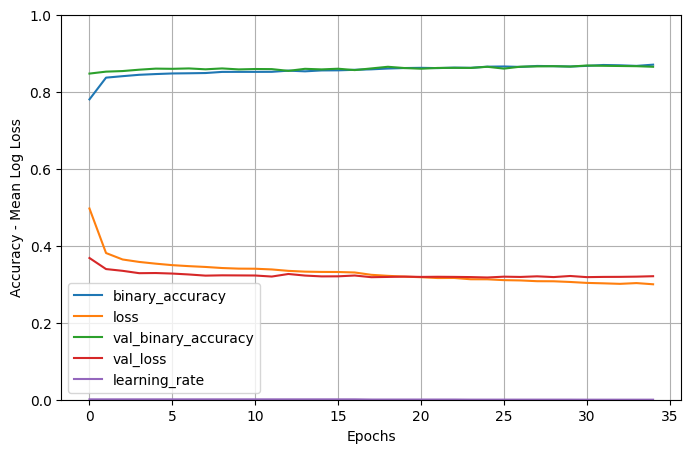

In [ ]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # imposta il range verticale nell'intervallo [0,1]
plt.show()

In [ ]:
history.params # visualizzazione dei prametri di training

{'verbose': 1, 'epochs': 150, 'steps': 495}

In [ ]:
results[-1:] # mostra gli ultimi risultati (ultima epoca)

,binary_accuracy,loss,val_binary_accuracy,val_loss,learning_rate
34,0.870274,0.299868,0.864797,0.320802,0.000125


In [ ]:
print ("Accuracy for the training set: ", results.binary_accuracy.values[-1:][0])

Accuracy for the training set:  0.8702738285064697


In [ ]:
print ("Accuracy per il development test set: ", results.val_binary_accuracy.values[-1:][0])

Accuracy per il development test set:  0.8647965788841248


In [ ]:
dev_predictions=model.predict(x_dev).round(2)
dev_predictions[:20]

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


array([[0.11],
       [0.17],
       [0.15],
       [0.9 ],
       [0.01],
       [0.01],
       [0.02],
       [0.16],
       [0.66],
       [0.01],
       [0.22],
       [0.37],
       [0.65],
       [0.23],
       [0.08],
       [0.02],
       [0.08],
       [0.41],
       [0.45],
       [0.02]], dtype=float32)

In [ ]:
# Previsioni sul validation set (arrotondate a 2 decimali)
dev_rounded_predictions=np.round(dev_predictions)
indices = np.argmax(dev_predictions,1)
for row, index in zip(dev_rounded_predictions, indices): row[index]=1
dev_rounded_predictions[:20]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
t_dev[:20] #target classes

array([[0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [ ]:
dev_correct_predictions = np.equal(np.argmax(dev_rounded_predictions,1),np.argmax(t_dev,1))
print (dev_correct_predictions[:30])

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


In [ ]:
from collections import Counter
Counter (dev_correct_predictions)

Counter({np.True_: 3957})

## Test finale

In [ ]:
# Il 10% rimanente del dataset viene utilizzato per il test finale
n_final_test = n_instances-n_train-n_dev

x_final_test = attributes.values[n_train+n_dev:n_instances]
t_final_test = label.values[n_train+n_dev:n_instances]

print ("x_test:",x_final_test.shape)
print ("t_test:",t_final_test.shape)

x_test: (3958, 21)
t_test: (3958, 1)


In [ ]:
model.evaluate(x_final_test, t_final_test)

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.8580 - loss: 0.3333


[0.31729796528816223, 0.8620515465736389]

In [ ]:
test_predictions=model.predict(x_final_test)
test_rounded_predictions=np.round(test_predictions)
indices = np.argmax(test_predictions,1)
for row, index in zip(test_rounded_predictions, indices): row[index]=1
test_rounded_predictions[:20]

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
t_final_test[:20]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [ ]:
test_correct_predictions = np.equal(np.argmax(test_rounded_predictions,1),np.argmax(t_final_test,1))
test_correct_predictions[:30]
# Prime 30 predizioni, True = corretto

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [ ]:
final_test_prediction_results=Counter(test_correct_predictions)
final_test_prediction_results

Counter({np.True_: 3958})

In [ ]:
final_test_prediction_results[True]/sum(final_test_prediction_results.values())

1.0

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.8621
Precision: 0.7423
Recall: 0.5593
F1 Score: 0.6379


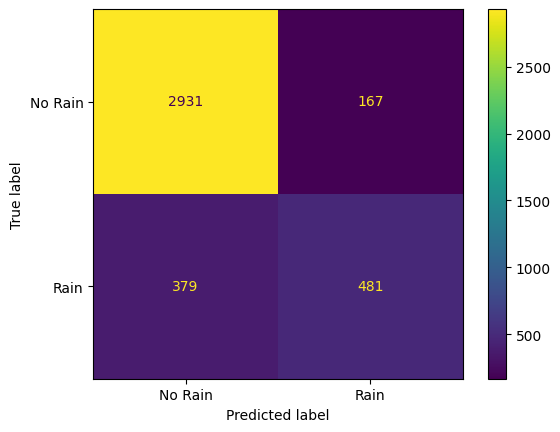

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

t_pred_prob = model.predict(x_final_test)
t_pred = (t_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(t_final_test, t_pred)
precision = precision_score(t_final_test, t_pred)
recall = recall_score(t_final_test, t_pred)
f1 = f1_score(t_final_test, t_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Matrice di confusione
conf_matrix = confusion_matrix(t_final_test, t_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["No Rain", "Rain"])
disp.plot()
plt.show()

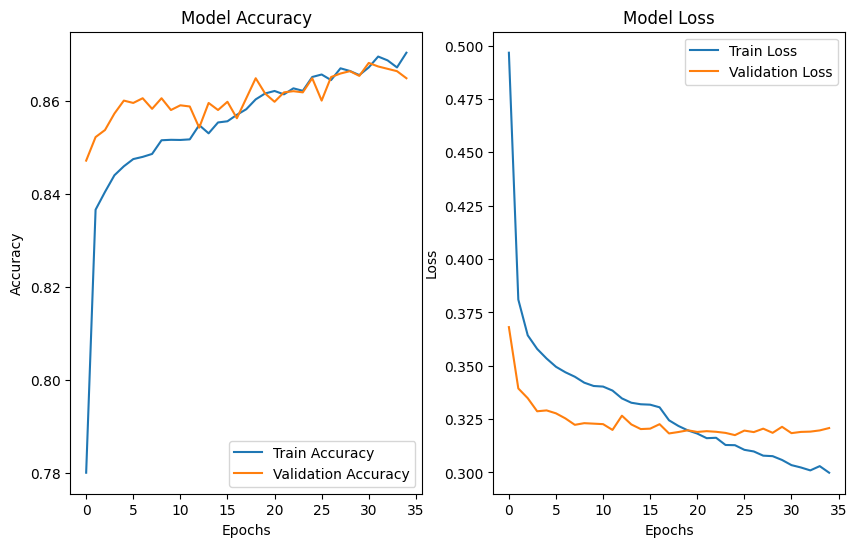

In [ ]:
plt.figure(figsize=(10, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


In [ ]:
train_acc = history.history['binary_accuracy'][-1]
val_acc = history.history['val_binary_accuracy'][-1]

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")

if abs(train_acc - val_acc) > 0.05:
    print("high variance")
elif train_acc < 0.75 and val_acc < 0.75:
    print("high bias")
else:
    print("Model has a good bias-variance tradeoff!")


Final Training Accuracy: 0.8703
Final Validation Accuracy: 0.8648
Model has a good bias-variance tradeoff!


In [ ]:
# Valori finali della loss
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f"Training Loss finale: {train_loss:.4f}")
print(f"Validation Loss finale: {val_loss:.4f}")

if val_loss > train_loss + 0.05:
    print("alta varianza")
elif train_loss > 0.5 and val_loss > 0.5:
    print("alto bias")
else:
    print("Modello ha un buon equilibrio tra bias e varianza")


Training Loss finale: 0.2999
Validation Loss finale: 0.3208
Modello ha un buon equilibrio tra bias e varianza


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

t_train_pred = (model.predict(x_train) > 0.5).astype(int)

t_test_pred = (model.predict(x_final_test) > 0.5).astype(int)

train_precision = precision_score(t_train, t_train_pred)
test_precision = precision_score(t_final_test, t_test_pred)

train_recall = recall_score(t_train, t_train_pred)
test_recall = recall_score(t_final_test, t_test_pred)

train_f1 = f1_score(t_train, t_train_pred, average='binary')
test_f1 = f1_score(t_final_test, t_test_pred, average='binary')

print(f"Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}")
print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")

if abs(train_f1 - test_f1) > 0.05:
    print("Test performance è peggio della performance del Train")
elif train_f1 < 0.6 and test_f1 < 0.6:
    print("Entrambi train e test scores sono bassi")
else:
    print("Modello generalizza bene")


990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train Precision: 0.7977, Test Precision: 0.7423
Train Recall: 0.5945, Test Recall: 0.5593
Train F1 Score: 0.6813, Test F1 Score: 0.6379
Modello generalizza bene


In [ ]:
# Report di classificazione
print(classification_report(t_final_test,t_test_pred,target_names=['No_Rain','Rain']))

              precision    recall  f1-score   support

     No_Rain       0.89      0.95      0.91      3098
        Rain       0.74      0.56      0.64       860

    accuracy                           0.86      3958
   macro avg       0.81      0.75      0.78      3958
weighted avg       0.85      0.86      0.85      3958



## Conclusioni

In questo progetto è stata sviluppata una rete neurale profonda per la previsione della pioggia del giorno successivo in Australia, utilizzando un dataset meteorologico reale.

Dopo una fase di preprocessing condotta separatamente (normalizzazione, encoding, gestione dei missing values), è stato progettato e ottimizzato un modello con 7 layer nascosti, regolarizzato tramite **dropout** e **batch normalization**, e addestrato con l’ottimizzatore **Adam**.

Durante la fase sperimentale sono state testate diverse configurazioni di iperparametri e tecniche di ottimizzazione. Il modello finale ha raggiunto:
- Accuracy su test finale: 0.84
- Bias stimato: 14.86%
- Varianza stimata: 0.24%
- F1-score test: 0.66

Il bilanciamento delle classi è stato gestito efficacemente tramite `class_weight='balanced'` durante l’addestramento, senza alterare il dataset tramite oversampling.

Il modello ha dimostrato buona capacità di generalizzazione, evitando overfitting e mantenendo performance stabili sia su training che test set.